In [16]:
# Import Packages
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
import matplotlib.pyplot as plt
import seaborn as sns
numpy2ri.activate()

Balancesampling = importr('BalancedSampling')
cube = Balancesampling.cube

In [18]:
# Definition of Estimated Variance
#def Var_classical()

def Var_bern(Y, Yhat, xi, pi):
    selected = np.where(xi == 1)[0]
    residuals_sq = (Y[selected] - Yhat[selected]) ** 2
    terms = residuals_sq * (1 - pi[selected]) / (pi[selected] ** 2)
    variance_estimate = terms.sum() / (len(Y) ** 2)
    return variance_estimate

def Var_cube(Y, X, xi, pi, N, max_iter=100, tol=1e-6):
    selected = np.where(xi == 1)[0]
    Y_sample = Y[selected]
    X_sample = X[selected, :]
    pi_sample = pi[selected]

    n, p = len(Y_sample), X_sample.shape[1]
    c = (n / (n - p)) * (1 - pi_sample)

    for _ in range(max_iter):
        M = sum((c[i] / pi_sample[i] ** 2) * np.outer(X_sample[i], X_sample[i]) for i in range(n))
        c_new = np.zeros(n)
        M_inv = np.linalg.inv(M)

        for k in range(n):
            x_k = X_sample[k]
            A = (x_k @ M_inv @ x_k) / pi_sample[k]
            disc = 1 + 4 * A * (1 - pi_sample[k])
            if disc < 0 or A == 0:
                c_new[k] = 1 - pi_sample[k]
            else:
                c_new[k] = (-1 + np.sqrt(disc)) / (2 * A)

        if np.max(np.abs(c_new - c)) < tol:
            break
        c = c_new

    weights = c / (pi_sample ** 2)
    XtW = (X_sample.T * weights)
    XtWX = XtW @ X_sample
    XtWY = XtW @ Y_sample
    b = np.linalg.solve(XtWX, XtWY)
    residuals = Y_sample - X_sample @ b

    variance_estimate = (c * residuals ** 2 / pi_sample ** 2).sum() / (N ** 2)
    return variance_estimate

In [20]:
# Import & Split Dataset
np.random.seed(0)
data = pd.read_csv('C:/Users/C/Desktop/active 1/creditcard.csv').dropna()
data.head()

X_all = data.drop('Class', axis=1).values
y_all = data.Class.values

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=0)

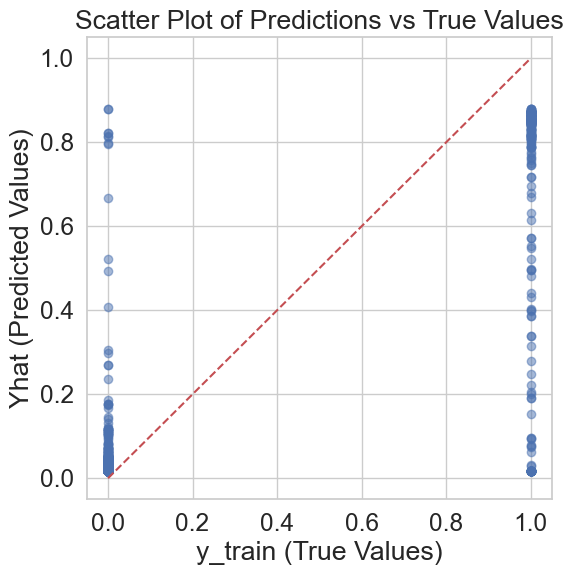

In [21]:
# Train Models & Initial Parameters
model = XGBRegressor(n_estimators=2000, learning_rate=0.001, max_depth=7, objective='reg:logistic')
model.fit(X_train, y_train)
Yhat = model.predict(X_test)

uncertainty = np.abs(np.minimum(Yhat, 1 - Yhat))
theta_true = y_test.mean()
N = len(y_test)

qn = norm.ppf(0.95)
tau = 0.5

plt.figure(figsize=(6, 6))
plt.scatter(y_test, Yhat, alpha=0.5)
plt.xlabel('y_train (True Values)')
plt.ylabel('Yhat (Predicted Values)')
plt.title('Scatter Plot of Predictions vs True Values')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')  # 画出对角线
plt.grid(True)
plt.show()

In [23]:
# Experiment
# Single Trial
def single_trial(seed, pi, pe, budget, qn, theta_true, y_test, Yhat, uncertainty, N):
    np.random.seed(seed)

    results_bias_sq = []
    results_ci = []
    results_cv = []
    results_lb = []
    results_hb = []

    methods = ['uniform', 'poisson_active', 'cube_active', 'classical']

    # Poisson Uniform Sampling
    xi_1 = np.random.binomial(1, pe)
    est_1 = (Yhat + (y_test - Yhat) * xi_1 / pe).mean()
    Std_1 = np.sqrt(Var_bern(y_test, Yhat, xi_1, pe))
    Cf_1 = qn * Std_1
    lb_1, hb_1 = est_1 - Cf_1, est_1 + Cf_1
    results_bias_sq.append((est_1 - theta_true)**2)
    results_ci.append(2 * Cf_1)
    results_cv.append(int(lb_1 < theta_true < hb_1))
    results_lb.append(lb_1)
    results_hb.append(hb_1)

    # Poisson Active Sampling
    xi_2 = np.random.binomial(1, pi)
    est_2 = (Yhat + (y_test - Yhat) * xi_2 / pi).mean()
    Std_2 = np.sqrt(Var_bern(y_test, Yhat, xi_2, pi))
    Cf_2 = qn * Std_2
    lb_2, hb_2 = est_2 - Cf_2, est_2 + Cf_2
    results_bias_sq.append((est_2 - theta_true)**2)
    results_ci.append(2 * Cf_2)
    results_cv.append(int(lb_2 < theta_true < hb_2))
    results_lb.append(lb_2)
    results_hb.append(hb_2)

    # Cube Active Sampling Based On Yhat
    Yhat_r = numpy2ri.py2rpy(np.reshape(Yhat, (-1, 1)))
    pi_r = numpy2ri.py2rpy(pi)
    cube_result = cube(Yhat_r, prob=pi_r)
    xi_3 = np.zeros(N)
    xi_3[np.array(cube_result).astype(int) - 1] = 1
    est_3 = (Yhat + (y_test - Yhat) * xi_3 / pi).mean()
    Std_3 = np.sqrt(Var_cube(y_test - Yhat, Yhat.reshape(-1, 1), xi_3, pi, N))
    Cf_3 = qn * Std_3
    lb_3, hb_3 = est_3 - Cf_3, est_3 + Cf_3
    results_bias_sq.append((est_3 - theta_true)**2)
    results_ci.append(2 * Cf_3)
    results_cv.append(int(lb_3 < theta_true < hb_3))
    results_lb.append(lb_3)
    results_hb.append(hb_3)

    # Classical Simple Random Sampling
    xi_4 = np.random.binomial(1, pe)
    selected_samples_4 = y_test[xi_4 == 1]
    est_4 = selected_samples_4.mean()
    m = xi_4.sum()
    sample_var_4 = selected_samples_4.var(ddof=1)
    Std_4 = np.sqrt((1 - budget) * sample_var_4 / m)
    Cf_4 = qn * Std_4
    lb_4, hb_4 = est_4 - Cf_4, est_4 + Cf_4
    results_bias_sq.append((est_4 - theta_true)**2)
    results_ci.append(2 * Cf_4)
    results_cv.append(int(lb_4 < theta_true < hb_4))
    results_lb.append(lb_4)
    results_hb.append(hb_4)

    return results_bias_sq, results_ci, results_cv, results_lb, results_hb

# Simulation N Trials
def run_simulation(budget, N_trial, qn, theta_true, y_test, Yhat, uncertainty, tau, N):
    pi = np.minimum(tau * uncertainty / uncertainty.mean() * budget + (1 - tau) * budget, 1)
    pe = np.full(N, budget)

    results = Parallel(n_jobs=32)(
        delayed(single_trial)(seed, pi, pe, budget, qn, theta_true, y_test, Yhat, uncertainty, N)
        for seed in range(N_trial))

    Result1 = np.sqrt(np.mean([r[0] for r in results], axis=0))
    Result2 = np.mean([r[1] for r in results], axis=0)
    Result3 = np.mean([r[2] for r in results], axis=0)
    Result4 = np.mean([r[3] for r in results], axis=0)
    Result5 = np.mean([r[4] for r in results], axis=0)

    return Result1, Result2, Result3, Result4, Result5, budget, len(results)

In [25]:
# Main
N_trials = 10000
budgets = np.arange(0.01, 0.26, 0.01)
results_list = [run_simulation(b, N_trials, qn, theta_true, y_test, Yhat, uncertainty, tau, N) for b in budgets]

columns = ['uniform', 'poisson_active', 'cube_active', 'classical', 'budget', 'SuccessCount']
Result1 = pd.DataFrame([x[0].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result2 = pd.DataFrame([x[1].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result3 = pd.DataFrame([x[2].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result4 = pd.DataFrame([x[3].tolist() + [x[5], x[6]] for x in results_list], columns=columns)
Result5 = pd.DataFrame([x[4].tolist() + [x[5], x[6]] for x in results_list], columns=columns)

D:\Anaconda\Ana\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


     uniform  poisson_active  cube_active  classical  budget  SuccessCount
0   0.000728        0.000631     0.000557   0.001079    0.01         10000
1   0.000510        0.000447     0.000389   0.000764    0.02         10000
2   0.000412        0.000362     0.000312   0.000624    0.03         10000
3   0.000354        0.000310     0.000267   0.000535    0.04         10000
4   0.000314        0.000275     0.000235   0.000478    0.05         10000
5   0.000286        0.000249     0.000209   0.000437    0.06         10000
6   0.000262        0.000228     0.000192   0.000402    0.07         10000
7   0.000244        0.000212     0.000177   0.000374    0.08         10000
8   0.000229        0.000198     0.000163   0.000351    0.09         10000
9   0.000218        0.000187     0.000154   0.000331    0.10         10000
10  0.000207        0.000176     0.000143   0.000313    0.11         10000
11  0.000197        0.000168     0.000137   0.000299    0.12         10000
12  0.000188        0.000

In [27]:
Result1.to_csv("CFD_Result1.csv", index=False)
Result2.to_csv("CFD_Result2.csv", index=False)
Result3.to_csv("CFD_Result3.csv", index=False)
Result4.to_csv("CFD_Result4.csv", index=False)
Result5.to_csv("CFD_Result5.csv", index=False)

print(Result1)
print(Result2)
print(Result3)
print(Result4)
print(Result5)

     uniform  poisson_active  cube_active  classical  budget  SuccessCount
0   0.000728        0.000631     0.000557   0.001079    0.01         10000
1   0.000510        0.000447     0.000389   0.000764    0.02         10000
2   0.000412        0.000362     0.000312   0.000624    0.03         10000
3   0.000354        0.000310     0.000267   0.000535    0.04         10000
4   0.000314        0.000275     0.000235   0.000478    0.05         10000
5   0.000286        0.000249     0.000209   0.000437    0.06         10000
6   0.000262        0.000228     0.000192   0.000402    0.07         10000
7   0.000244        0.000212     0.000177   0.000374    0.08         10000
8   0.000229        0.000198     0.000163   0.000351    0.09         10000
9   0.000218        0.000187     0.000154   0.000331    0.10         10000
10  0.000207        0.000176     0.000143   0.000313    0.11         10000
11  0.000197        0.000168     0.000137   0.000299    0.12         10000
12  0.000188        0.000

142404


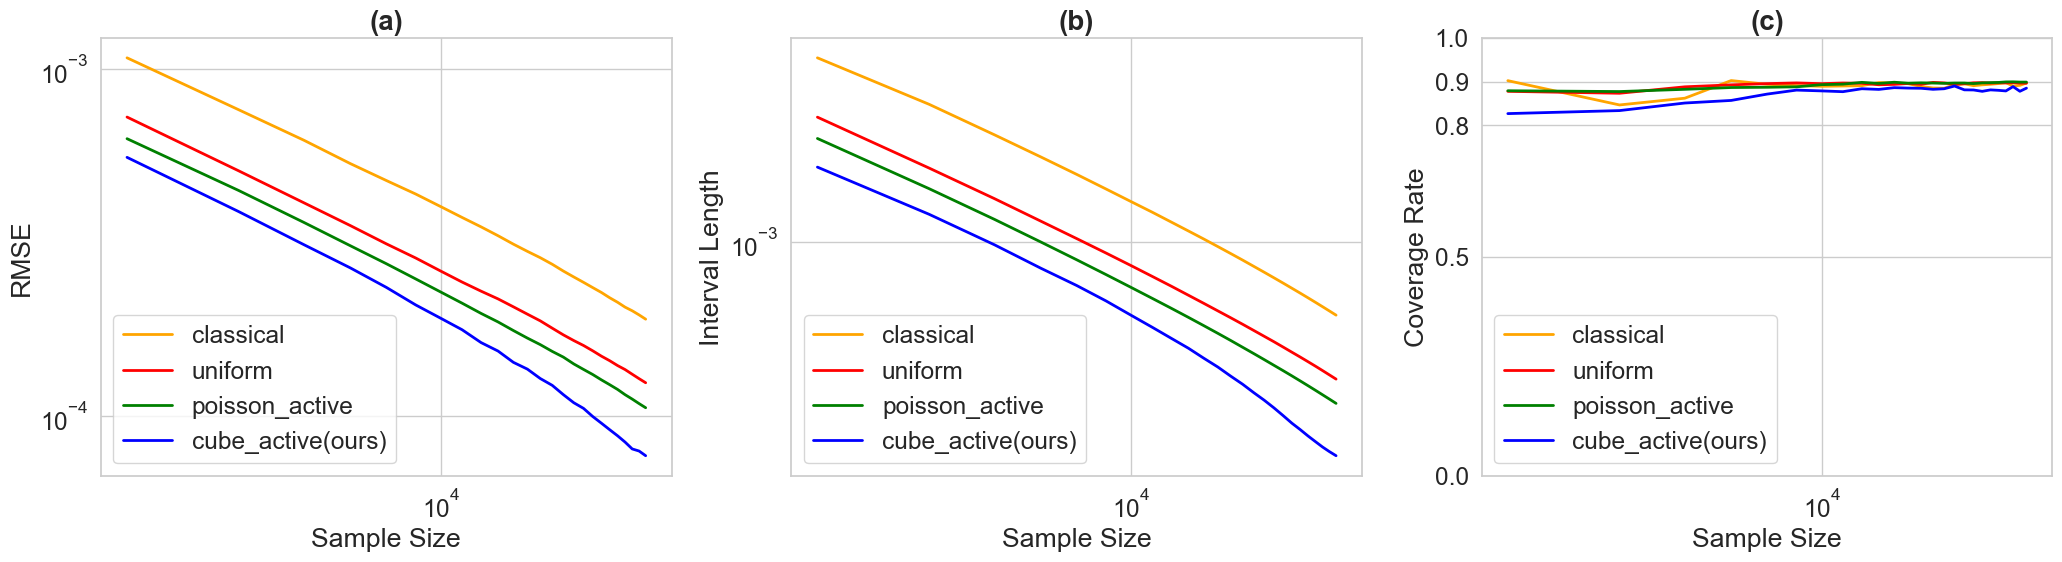

In [24]:
# Plot
Result1 = pd.read_csv("CFD_Result1.csv")
Result2 = pd.read_csv("CFD_Result2.csv")
Result3 = pd.read_csv("CFD_Result3.csv")

sns.set(style="whitegrid", font_scale=1.6)

N = len(y_test) 
print(N)
# 调整方法顺序并将classical放到第一个，修改cube_active的标签
methods = ['classical', 'uniform', 'poisson_active', 'cube_active']  # 修改顺序
colors = {'uniform': 'red', 'poisson_active': 'green', 'cube_active': 'blue', 'classical': 'orange'}

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

def plot_results(ax, data, ylabel, log_scale=True, ylim_zero=False):
    for method in methods:
        # 修改cube_active的图例标签
        label = 'cube_active(ours)' if method == 'cube_active' else method
        ax.plot(data['budget'] * N, data[method], label=label, color=colors[method], linewidth=2)

    ax.set_xlabel("Sample Size")
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')
    if log_scale:
        ax.set_yscale('log')
    if ylim_zero:
        ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid(True)

# 以下部分保持不变
# RMSE (Result1)
plot_results(axes[0], Result1, "RMSE", log_scale=True)
axes[0].set_title("(a)", fontsize=20, fontweight='bold') 

# Interval Length (Result2)
plot_results(axes[1], Result2, "Interval Length", log_scale=True)
axes[1].set_title("(b)", fontsize=20, fontweight='bold') 

# Coverage Rate (Result3)
plot_results(axes[2], Result3, "Coverage Rate", log_scale=False, ylim_zero=True)
axes[2].set_title("(c)", fontsize=20, fontweight='bold') 
axes[2].set_ylim(0, 1)  
axes[2].set_yticks([0, 0.5,0.8 , 0.9, 1])

plt.tight_layout()
plt.savefig("CFD_result.pdf",  # 保存为PDF
            format='pdf',
            bbox_inches='tight',  # 去除多余白边
            dpi=1000)
plt.show()